In [125]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.filters import IEKF, Madgwick, ParticleFilter
from tools.objects import Gaussian
from tools import compare, data_processing, transform, utils
from tools.tools_ahrs import plot

from collections import defaultdict
from prettytable import PrettyTable

In [18]:
DATA = "tum" # 'tum' or 'record'
DOWNSCALE = 1

errors = {}

# Load Data

In [19]:
if DATA == 'tum':
    x3_path = os.path.join("../data", "TUM-VI", "imu0")
    mocap_path = os.path.join("../data", "TUM-VI", "mocap0")
    take_name = "outdoors1.csv"

    t_base, data_gyr, data_acc = data_processing.import_tum_imu(os.path.join(x3_path, take_name), smoothing=False)
    t_base, data_gyr, data_acc = data_processing.downsample(DOWNSCALE, t_base, data_gyr, data_acc)

    freq_tum = 120/DOWNSCALE # Hz

    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.import_tum_mocap(os.path.join(mocap_path, take_name), smoothing=False)
    data_mocap_t, data_mocap_q, data_mocap_T = data_processing.downsample(DOWNSCALE, data_mocap_t, data_mocap_q, data_mocap_T)

    t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

else:
    x3_path_my = os.path.join("../data", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
    # x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
    # x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

    mocap_path_my = os.path.join("../data", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
    # mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"

    freq_record = 100 # Hz

    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

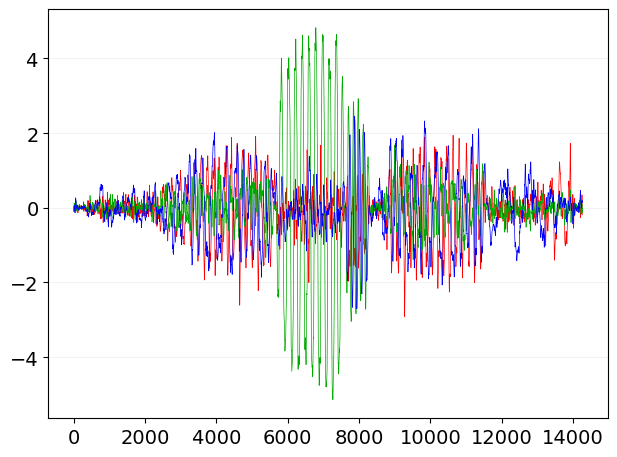

In [20]:
plot(data_gyr)

# Apply filter

## IEKF

In [98]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

for i in range(N):
    iekf.predict(u[i], dts[i])
    Ks[i], IVs[i] = iekf.update(data_acc[i])
    #iekf.update_fake()
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma

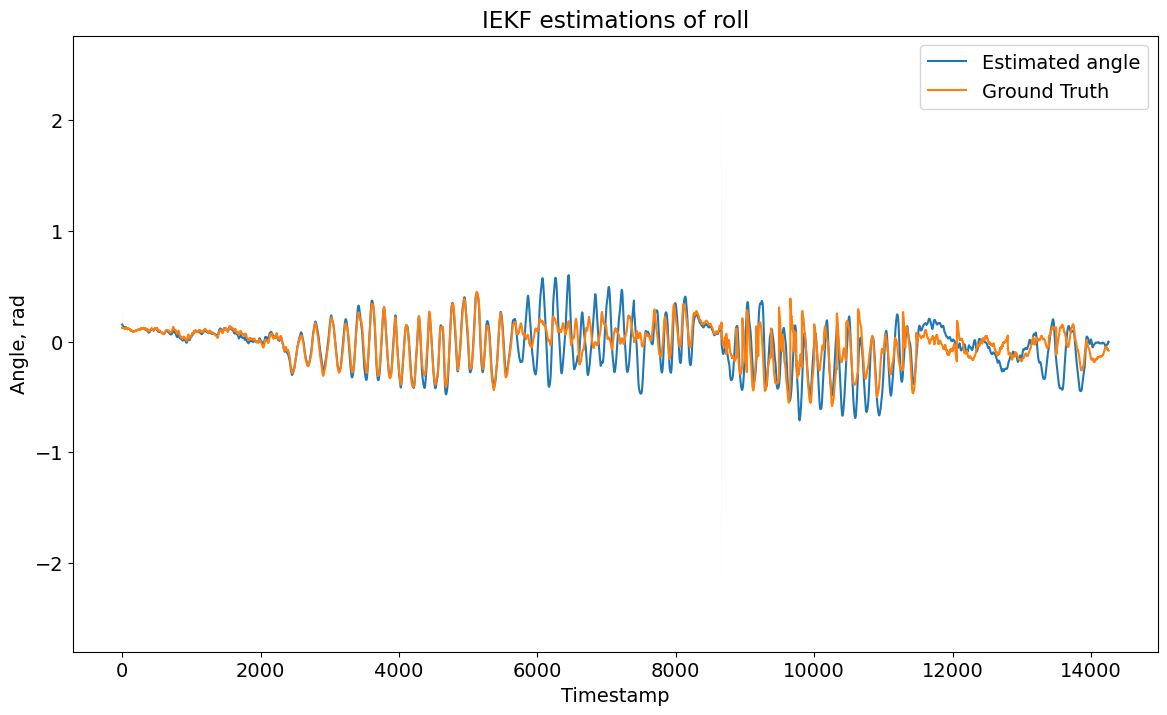

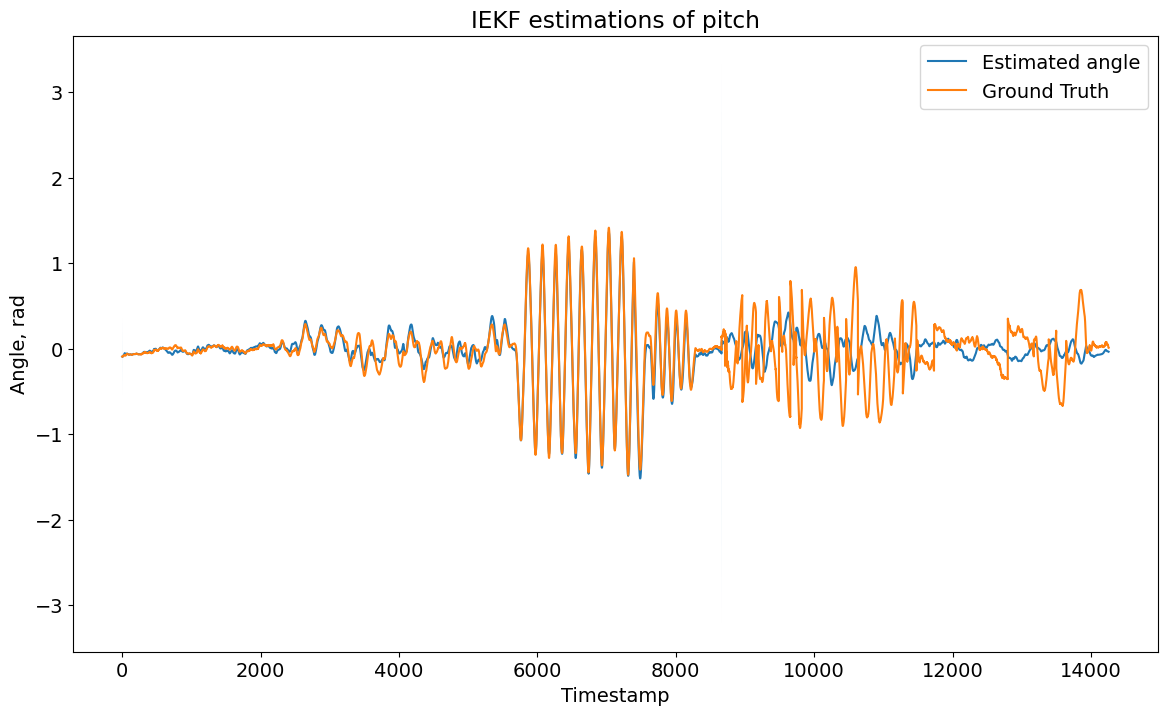

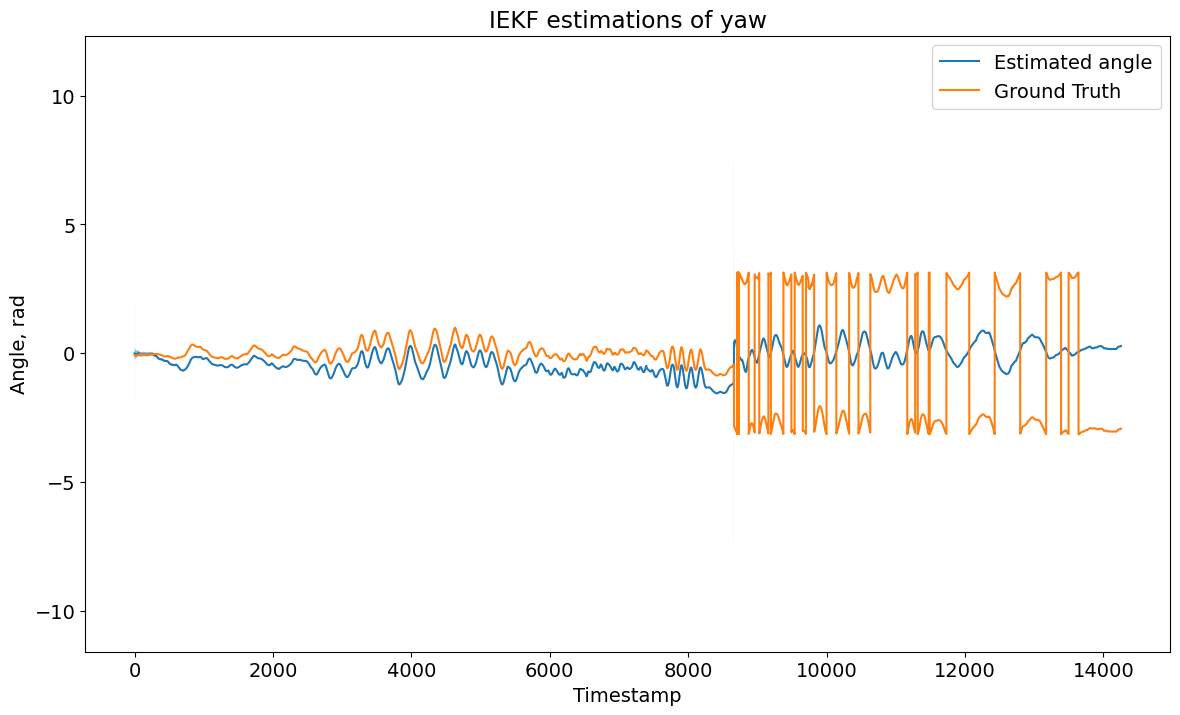

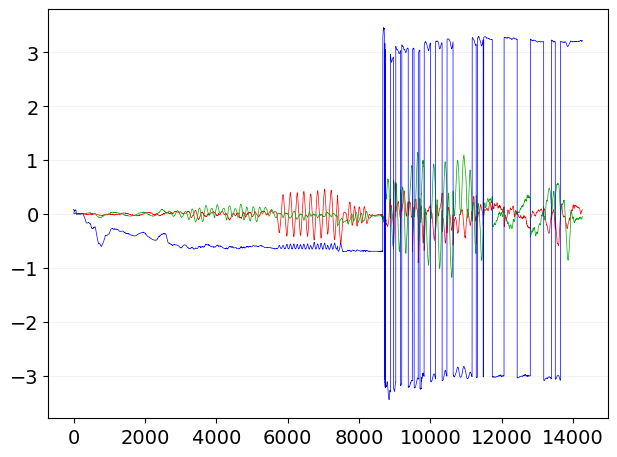

In [99]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

Mean distance between smartphone and mocap RPY attitude estimations:
[0.10339858 0.1570343  1.54806329]
STD of distance between smartphone and mocap RPY attitude estimations:
[0.16117913 0.27350979 1.99316718]
Distance between smartphone and mocap RPY attitude estimations:


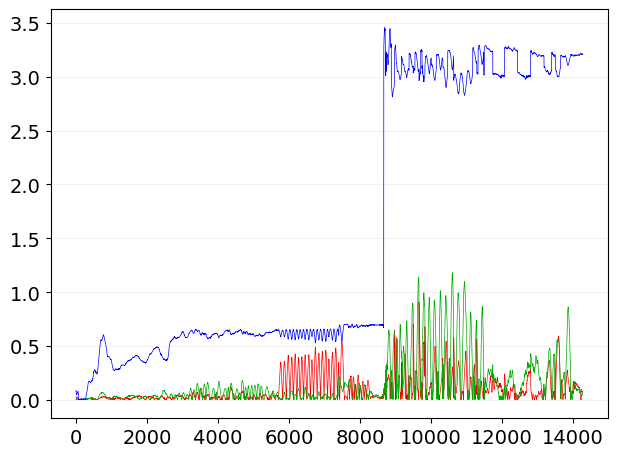

Last distance between smartphone and mocap RPY attitude estimations:
[0.08103224 0.04545753 3.20982695]
RMSE of APE between smartphone and mocap RPY attitude estimations:
[0.16252303 0.27398309 2.00132873]


Mean distance between smartphone and mocap RPY vector g estimations:
[0.01936411 0.02655647 0.00508398]
STD of distance between smartphone and mocap RPY vector g estimations:
[0.02686483 0.03704096 0.00832233]
Distance between smartphone and mocap RPY vector g estimations:


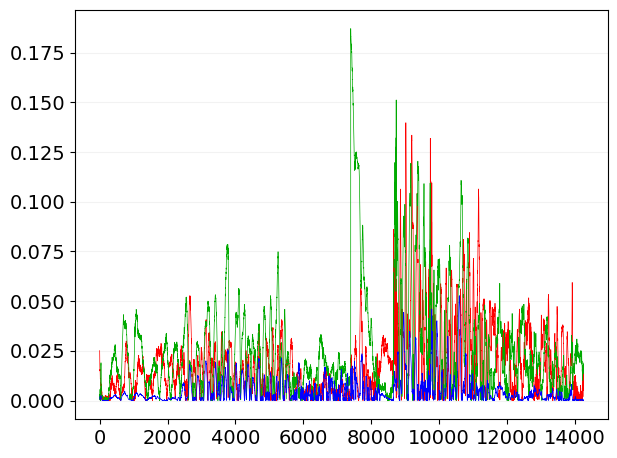

Last distance between smartphone and mocap RPY vector g estimations:
[5.20594456e-03 1.89154157e-02 6.20479018e-05]
RMSE of APE between smartphone and mocap RPY vector g estimations:
[0.02687562 0.03742038 0.00836054]


Mean Relative Pose Error
Mean distance between smartphone and mocap RPY attitude estimations:
[3.88497345 9.67873513 5.3948822 ]
STD of distance between smartphone and mocap RPY attitude estimations:
[ 39.4260571  155.34921171  95.88701473]
Relative Pose Error RPY


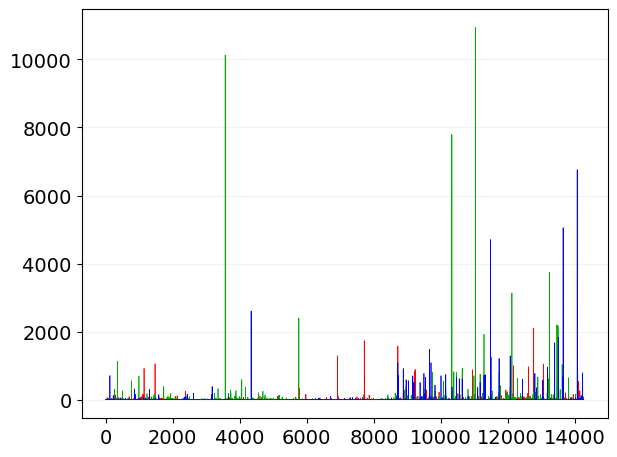

Last RPE between smartphone and mocap RPY attitude estimations:
[2.47947751 0.66360949 2.80942573]
RMSE of RPE between smartphone and mocap RPY attitude estimations:
[ 39.44033638 155.37119543  95.88722176]


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap RPY vector g estimations:
[5.32262733 4.15613969 5.59463321]
STD of distance between smartphone and mocap RPY vector g estimations:
[173.21060723  70.51200764 154.38122119]
Relative Pose Error RPY of vector g


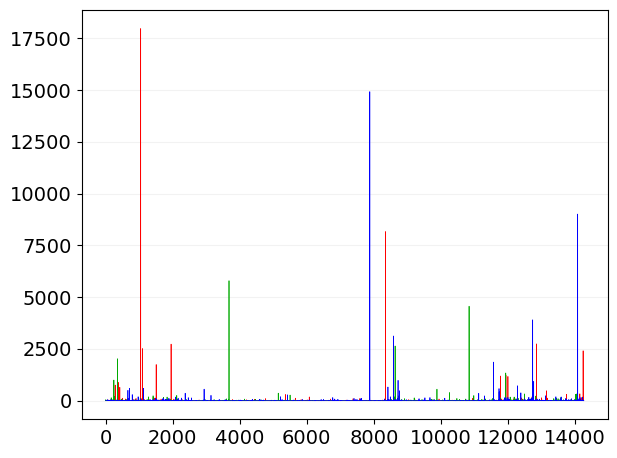

Last RPE between smartphone and mocap RPY vector g estimations:
[0.17111855 4.57064168 0.29834738]
RMSE of RPE between smartphone and mocap RPY vector g estimations:
[173.21038281  70.53137097 154.38084428]




In [100]:
(errors["iekf_rpy_ape_mean"], errors["iekf_rpy_ape_std"], errors["iekf_rpy_ape_rmse"],
errors["iekf_rpy_ape_g_mean"], errors["iekf_rpy_ape_g_std"], errors["iekf_rpy_ape_g_rmse"],
errors["iekf_rpy_rpe_mean"], errors["iekf_rpy_rpe_std"], errors["iekf_rpy_rpe_rmse"],
errors["iekf_rpy_rpe_g_mean"], errors["iekf_rpy_rpe_g_std"], errors["iekf_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(gt, ups)

In [24]:
print(errors["iekf_rpy_ape_mean"])
print(errors["iekf_rpy_ape_std"])
print(errors["iekf_rpy_ape_rmse"])

[0.10339858 0.1570343  1.54806329]
[0.16117913 0.27350979 1.99316718]
[0.16252303 0.27398309 2.00132873]


Mean distance between smartphone and mocap attitude estimations:
1.5293345238123401
STD of distance between smartphone and mocap attitude estimations:
1.228524116134872
Distance between smartphone and mocap attitude estimations:


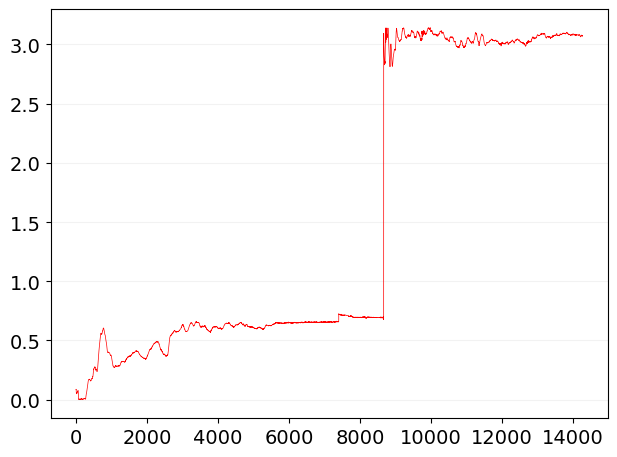

Last distance between smartphone and mocap attitude estimations:
3.0722095129389557
RMSE of APE between smartphone and mocap attitude estimations:
1.9616395490599305


G vectors in smartphone and (mocap-observed-smartphone) reference frames


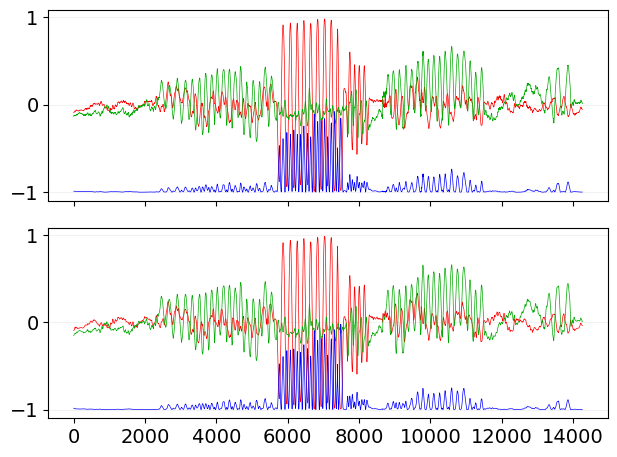

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


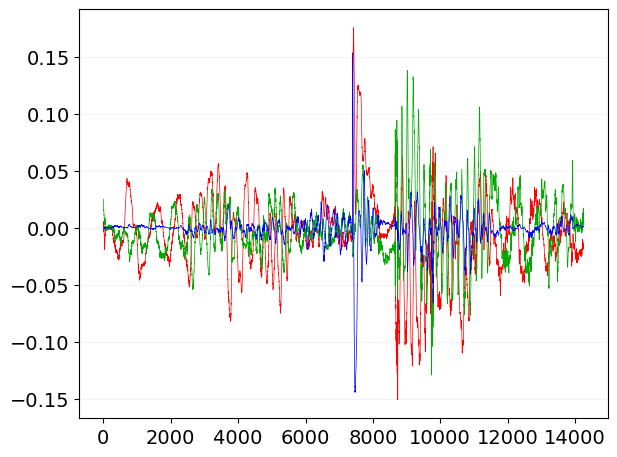

Mean distance between smartphone and mocap vector g estimations:
0.037238130718091844
STD of distance between smartphone and mocap vector g estimations:
0.02838768582867939
Distance between smartphone and mocap vector g estimations:


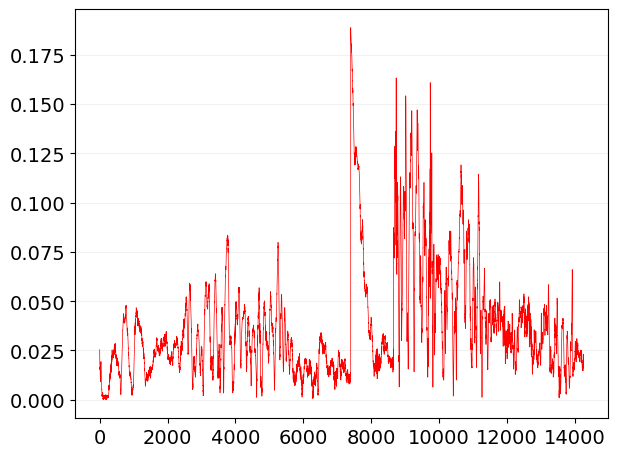

Last distance between smartphone and mocap vector g estimations:
0.019618834276804435
RMSE of APE between smartphone and mocap vector g estimations:
0.0468239528260713


Mean Relative Pose Error
Mean distance between smartphone and mocap attitude estimations:
0.0026568991364230993
STD of distance between smartphone and mocap attitude estimations:
0.020657043823287983
Relative Pose Error


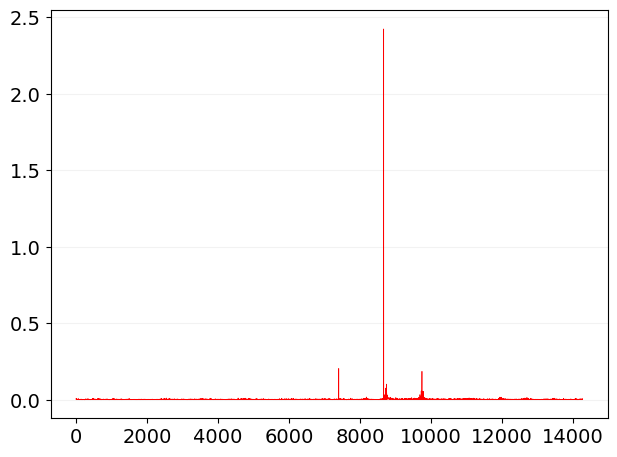

Last RPE between smartphone and mocap attitude estimations:
0.0046352435132367776
RMSE of RPE between smartphone and mocap attitude estimations:
0.020826488860041983


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap vector g estimations:
0.007964835209119166
STD of distance between smartphone and mocap vector g estimations:
0.02318269539363005
Relative Pose Error of vector g


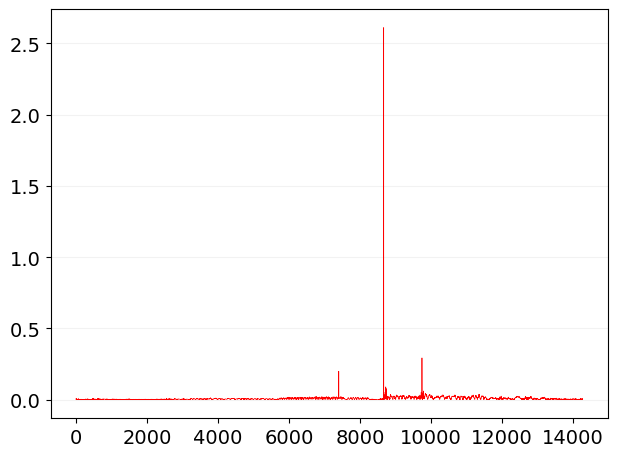

Last RPE between smartphone and mocap vector g estimations:
0.007087456165419162
RMSE of RPE between smartphone and mocap vector g estimations:
0.024512002446721092




In [101]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)

(errors["iekf_quat_ape_mean"], errors["iekf_quat_ape_std"], errors["iekf_quat_ape_rmse"],
errors["iekf_quat_ape_g_mean"], errors["iekf_quat_ape_g_std"], errors["iekf_quat_ape_g_rmse"],
errors["iekf_quat_rpe_mean"], errors["iekf_quat_rpe_std"], errors["iekf_quat_rpe_rmse"],
errors["iekf_quat_rpe_g_mean"], errors["iekf_quat_rpe_g_std"], errors["iekf_quat_rpe_g_rmse"]) = compare.errors_estimation(q1, q2)

In [103]:
errors["iekf_quat_ape_mean"]
errors["iekf_quat_ape_std"]
errors["iekf_quat_ape_rmse"]

1.9616395490599305

## Particle Filter (PF)

In [102]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
pf = ParticleFilter(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

for i in range(N):
    pf.predict(u[i], dts[i])
    pf.update(data_acc[i])
    preds[i, :] = pf.mu_bar
    s_preds[i] = pf.Sigma_bar
    ups[i] = pf.mu
    s_ups[i] = pf.Sigma

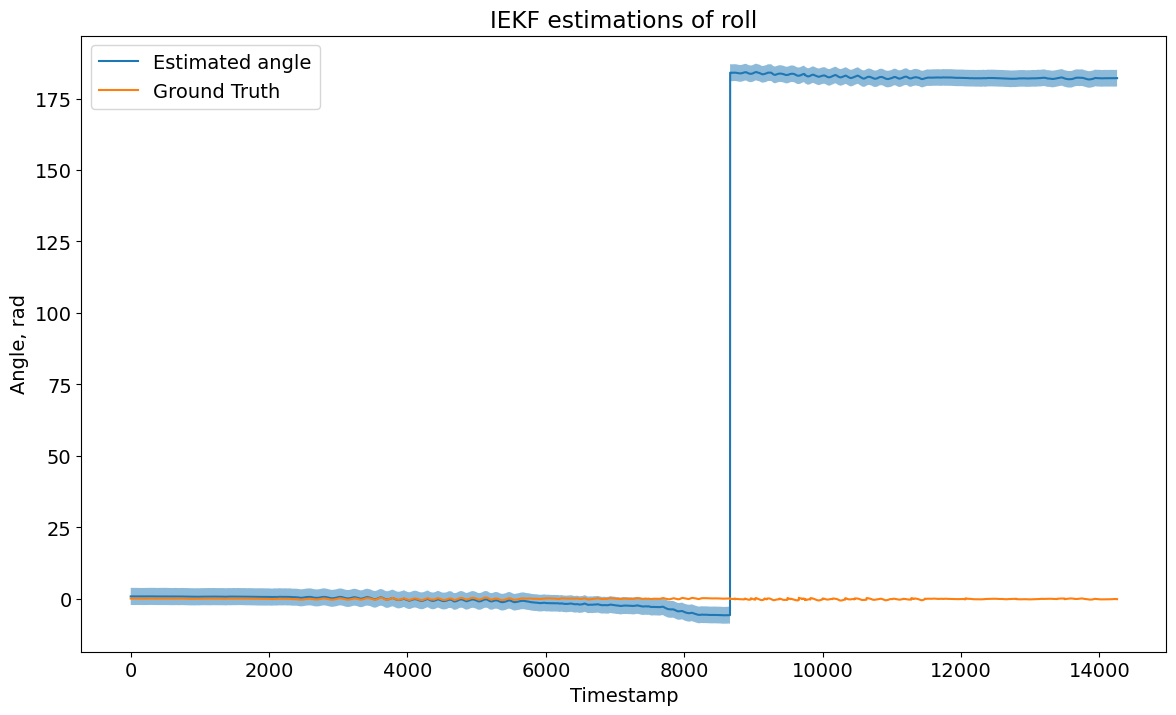

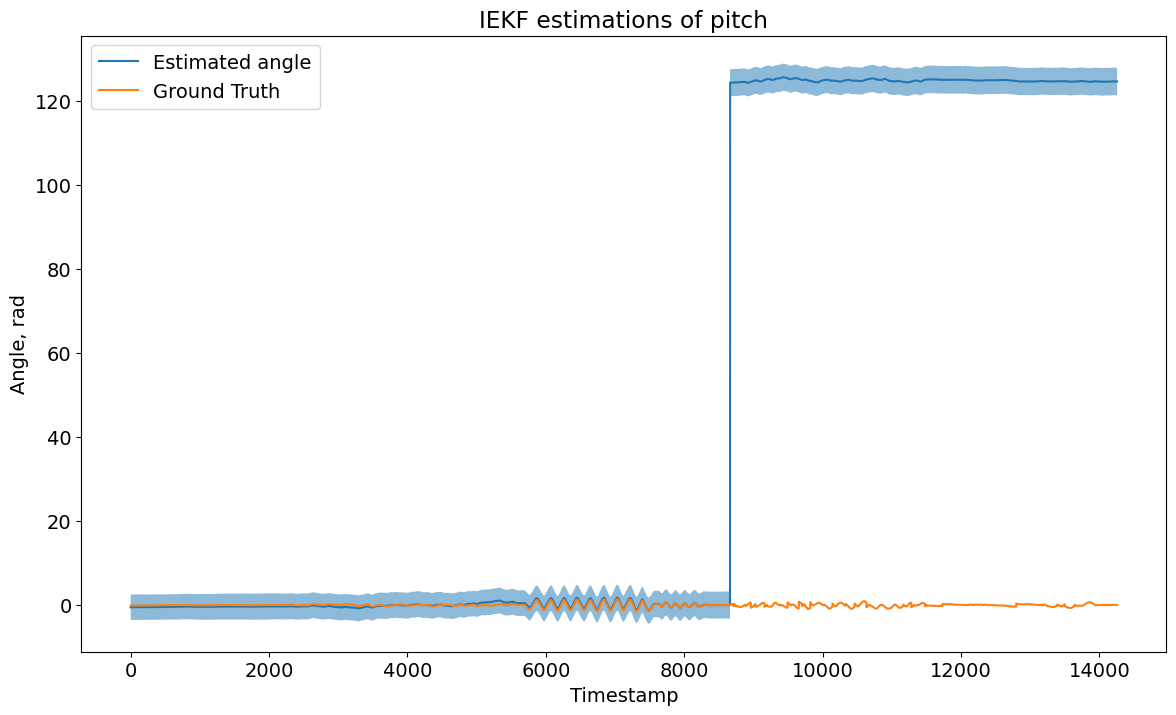

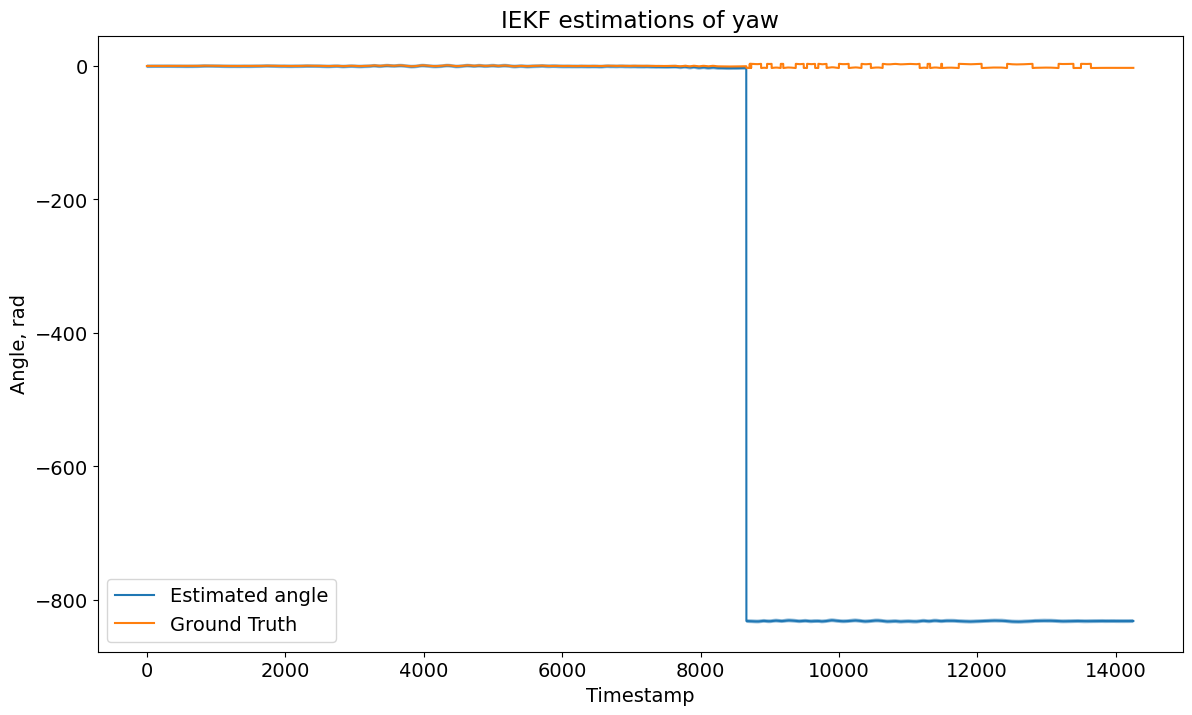

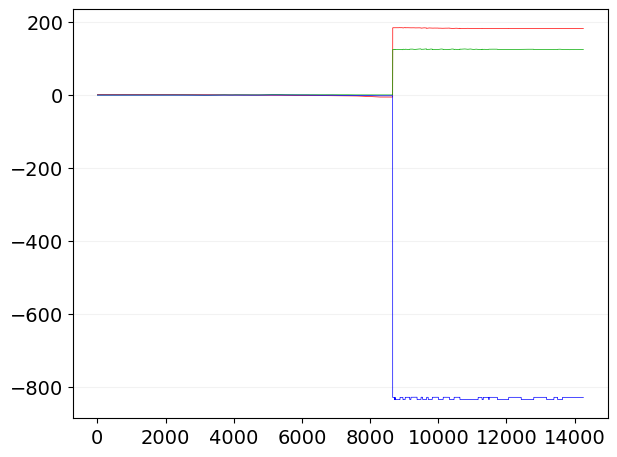

In [77]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

Mean distance between smartphone and mocap RPY attitude estimations:
[ 72.51054972  49.22504049 326.67461452]
STD of distance between smartphone and mocap RPY attitude estimations:
[ 89.61691694  61.01764388 405.61142129]
Distance between smartphone and mocap RPY attitude estimations:


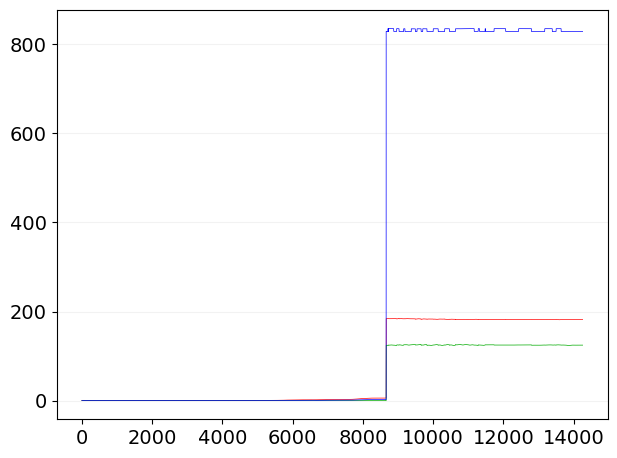

Last distance between smartphone and mocap RPY attitude estimations:
[182.20835473 124.6721324  828.65649527]
RMSE of APE between smartphone and mocap RPY attitude estimations:
[114.40371638  78.26763105 520.79303798]


Mean distance between smartphone and mocap RPY vector g estimations:
[0.46395618 0.28938742 0.13312133]
STD of distance between smartphone and mocap RPY vector g estimations:
[0.60386487 0.50602127 0.32605056]
Distance between smartphone and mocap RPY vector g estimations:


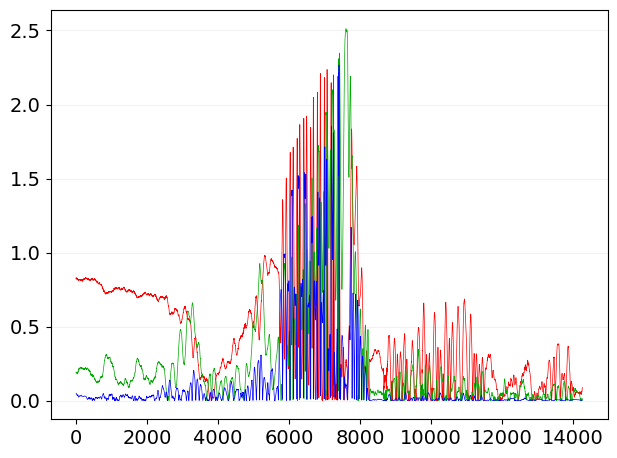

Last distance between smartphone and mocap RPY vector g estimations:
[0.088071   0.01326673 0.00501776]
RMSE of APE between smartphone and mocap RPY vector g estimations:
[0.60618215 0.51627332 0.32697698]


Mean Relative Pose Error
Mean distance between smartphone and mocap RPY attitude estimations:
[ 5.54952572  9.79122955 12.60130199]
STD of distance between smartphone and mocap RPY attitude estimations:
[143.11971744 159.16573116 474.16451356]
Relative Pose Error RPY


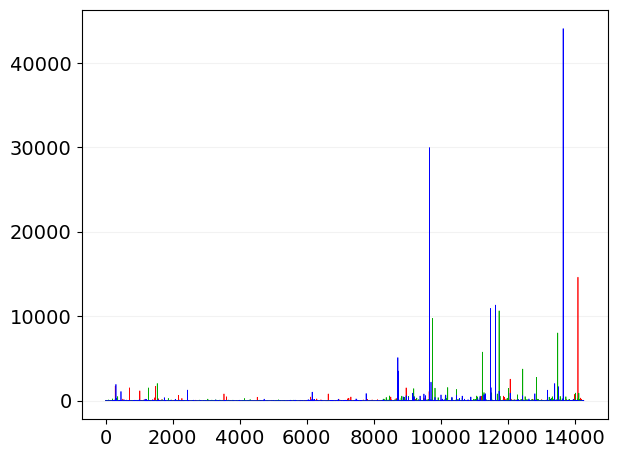

Last RPE between smartphone and mocap RPY attitude estimations:
[ 5.5565347   0.31220187 28.47401838]
RMSE of RPE between smartphone and mocap RPY attitude estimations:
[143.13852155 159.18459988 474.15126392]


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap RPY vector g estimations:
[  11.92722895   53.45727075 7080.9581015 ]
STD of distance between smartphone and mocap RPY vector g estimations:
[1.83095698e+02 1.28388508e+03 2.86567772e+05]
Relative Pose Error RPY of vector g


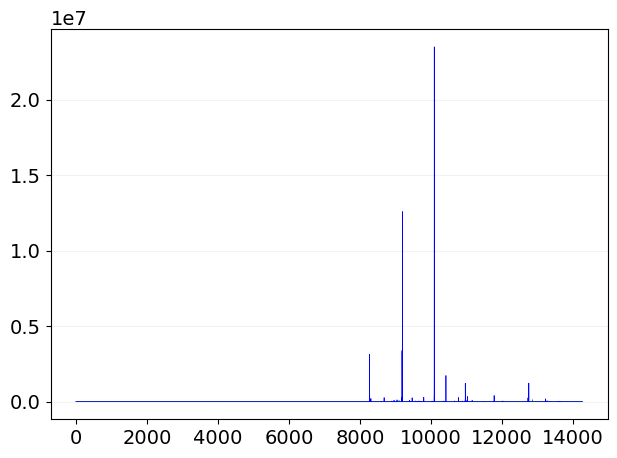

Last RPE between smartphone and mocap RPY vector g estimations:
[  2.48587645 134.96955006   7.39949367]
RMSE of RPE between smartphone and mocap RPY vector g estimations:
[1.83100919e+02 1.28384031e+03 2.86564426e+05]




In [78]:
(errors["pf_rpy_ape_mean"], errors["pf_rpy_ape_std"], errors["pf_rpy_ape_rmse"],
errors["pf_rpy_ape_g_mean"], errors["pf_rpy_ape_g_std"], errors["pf_rpy_ape_g_rmse"],
errors["pf_rpy_rpe_mean"], errors["pf_rpy_rpe_std"], errors["pf_rpy_rpe_rmse"],
errors["pf_rpy_rpe_g_mean"], errors["pf_rpy_rpe_g_std"], errors["pf_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(gt, ups)

Mean distance between smartphone and mocap attitude estimations:
1.8671028501389617
STD of distance between smartphone and mocap attitude estimations:
1.0058445321134357
Distance between smartphone and mocap attitude estimations:


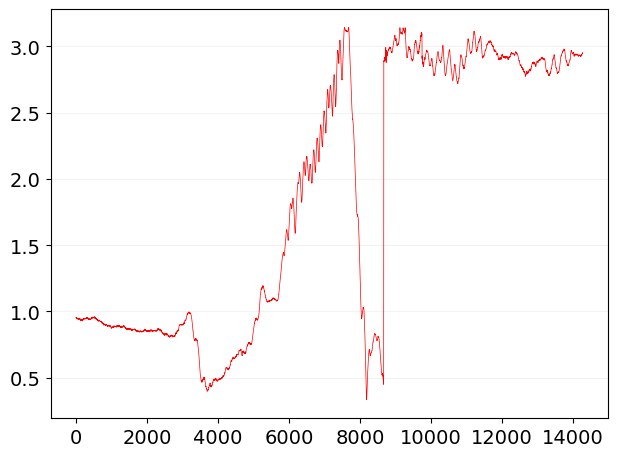

Last distance between smartphone and mocap attitude estimations:
2.951055683291048
RMSE of APE between smartphone and mocap attitude estimations:
2.120784125633724


G vectors in smartphone and (mocap-observed-smartphone) reference frames


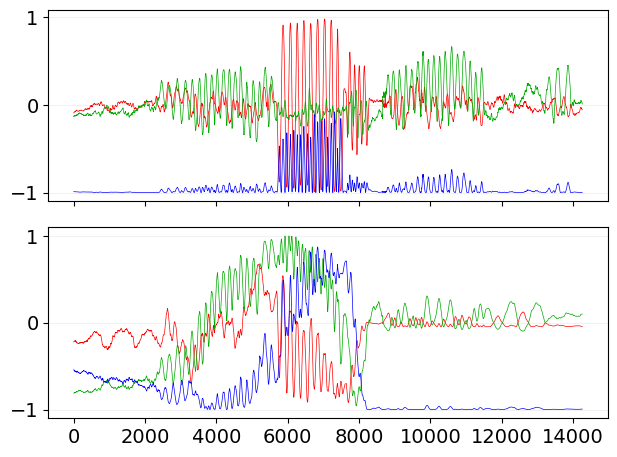

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


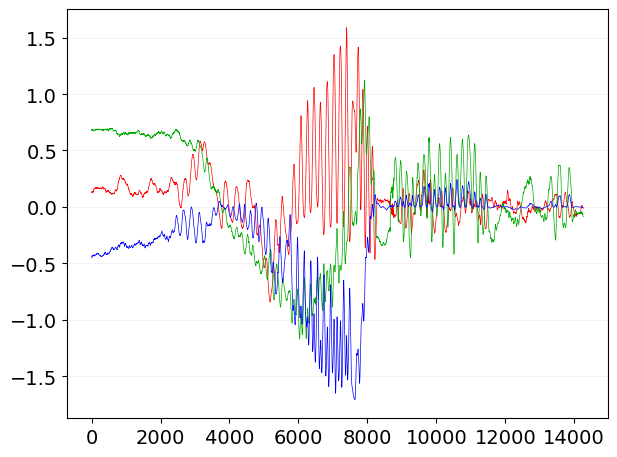

Mean distance between smartphone and mocap vector g estimations:
0.6405144349751266
STD of distance between smartphone and mocap vector g estimations:
0.5750420331094037
Distance between smartphone and mocap vector g estimations:


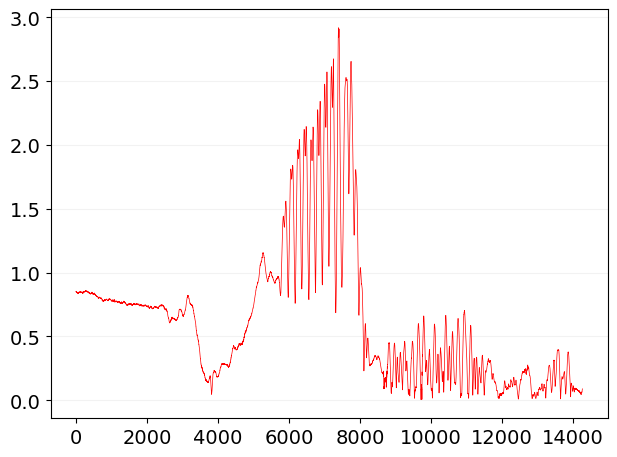

Last distance between smartphone and mocap vector g estimations:
0.0892058550454793
RMSE of APE between smartphone and mocap vector g estimations:
0.8607606437761444


Mean Relative Pose Error
Mean distance between smartphone and mocap attitude estimations:
0.008723931063725198
STD of distance between smartphone and mocap attitude estimations:
0.022577565124806912
Relative Pose Error


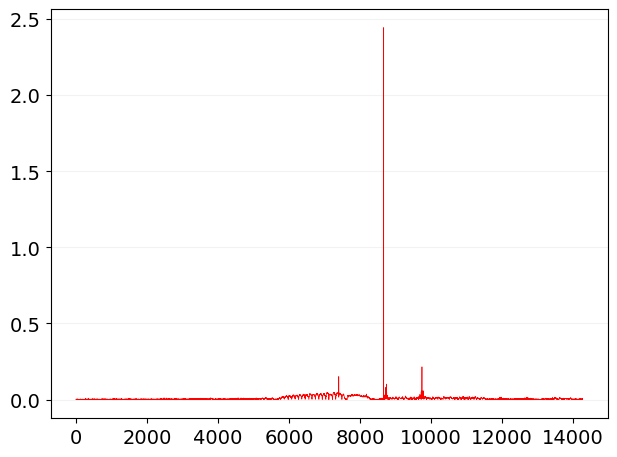

Last RPE between smartphone and mocap attitude estimations:
0.004949533966602829
RMSE of RPE between smartphone and mocap attitude estimations:
0.024203670404219738


Mean Relative Pose Error of vector g
Mean distance between smartphone and mocap vector g estimations:
0.010248060870851547
STD of distance between smartphone and mocap vector g estimations:
0.018216948856071686
Relative Pose Error of vector g


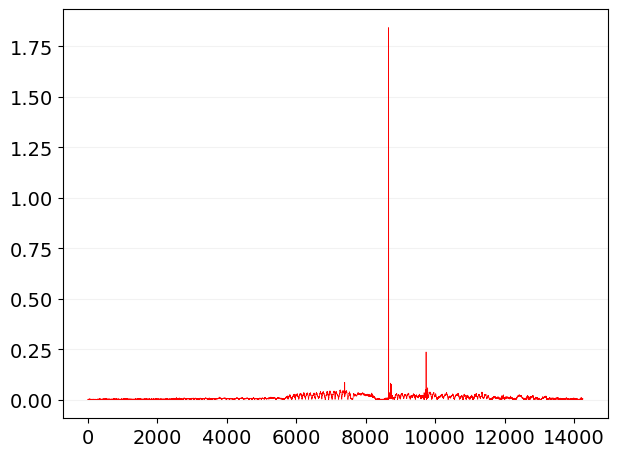

Last RPE between smartphone and mocap vector g estimations:
0.005668672278314698
RMSE of RPE between smartphone and mocap vector g estimations:
0.020901117127548274




In [79]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)

(errors["pf_quat_ape_mean"], errors["pf_quat_ape_std"], errors["pf_quat_ape_rmse"],
errors["pf_quat_ape_g_mean"], errors["pf_quat_ape_g_std"], errors["pf_quat_ape_g_rmse"],
errors["pf_quat_rpe_mean"], errors["pf_quat_rpe_std"], errors["pf_quat_rpe_rmse"],
errors["pf_quat_rpe_g_mean"], errors["pf_quat_rpe_g_std"], errors["pf_quat_rpe_g_rmse"]) = compare.errors_estimation(q1, q2)

## Madgwick

In [31]:
# i_start = 0
# t_base, data_gyr, data_acc, data_mocap_t, data_mocap_q = data_processing.arrays_from_i(i_start, t_base, data_gyr, data_acc, data_mocap_t, data_mocap_q)

madgwick_filter = Madgwick()
madgwick_result = madgwick_filter.apply(data_gyr=data_gyr,
                      data_acc=data_acc,
                      freq=freq_tum if DATA=="tum" else freq_record)


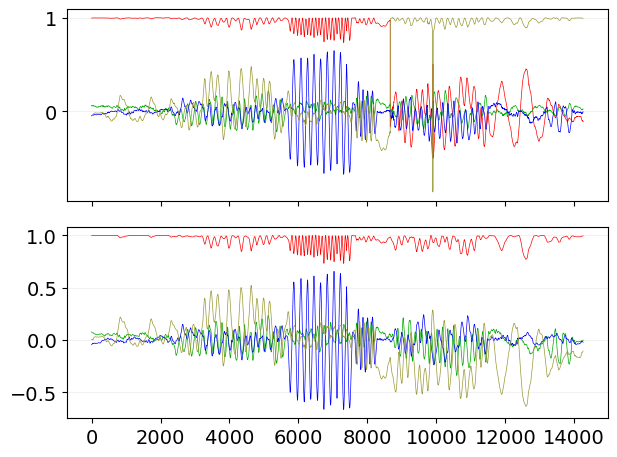

In [32]:
plot(data_mocap_q, madgwick_result.Q)

Mean distance between sensors and mocap attitude estimations:
1.1091480688282238
STD of distance between sensors and mocap attitude estimations:
1.247305933110516
Distance between sensors and mocap attitude estimations:


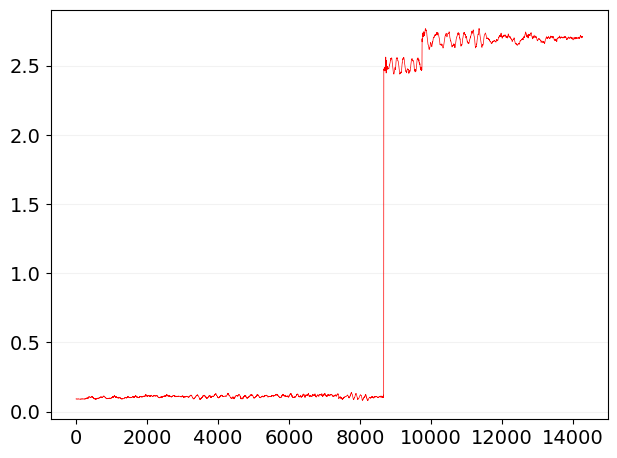

Last distance between sensors and mocap attitude estimations:
2.709050641193345
RMSE of APE between sensors and mocap attitude estimations:
1.6690932862842505


G vectors in smartphone and (mocap-observed-smartphone) reference frames


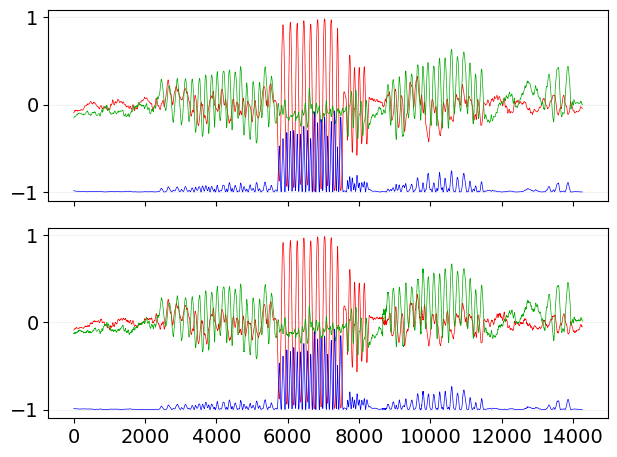

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


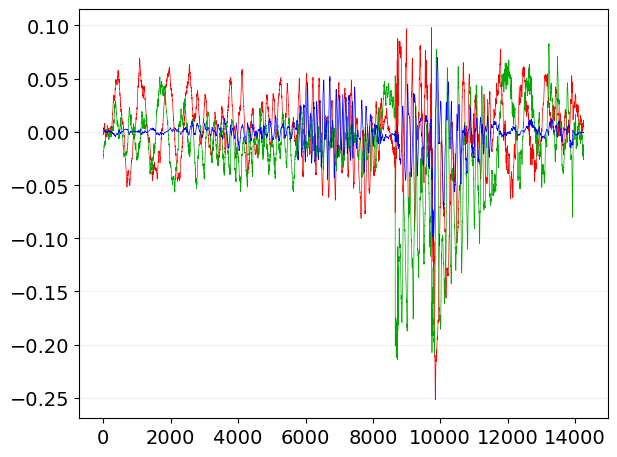

Mean distance between sensors and mocap vector g estimations:
0.04890385504217817
STD of distance between sensors and mocap vector g estimations:
0.041547967928648386
Distance between sensors and mocap vector g estimations:


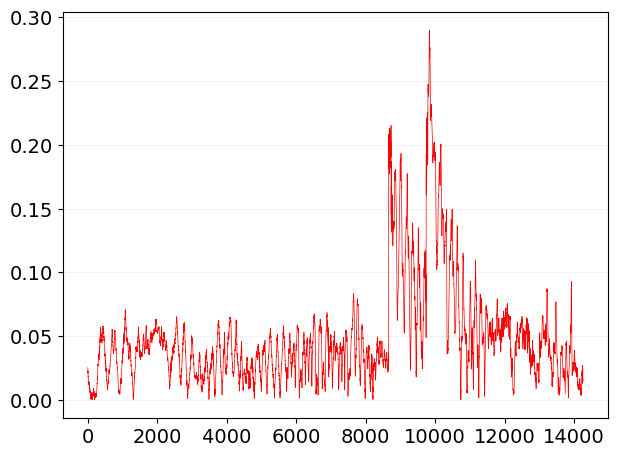

Last distance between sensors and mocap vector g estimations:
0.016734881957630565
RMSE of APE between sensors and mocap vector g estimations:
0.06416930410070026


Mean Relative Pose Error
Mean distance between sensors and mocap attitude estimations:
0.0026880924417294456
STD of distance between sensors and mocap attitude estimations:
0.0199846697598829
Relative Pose Error


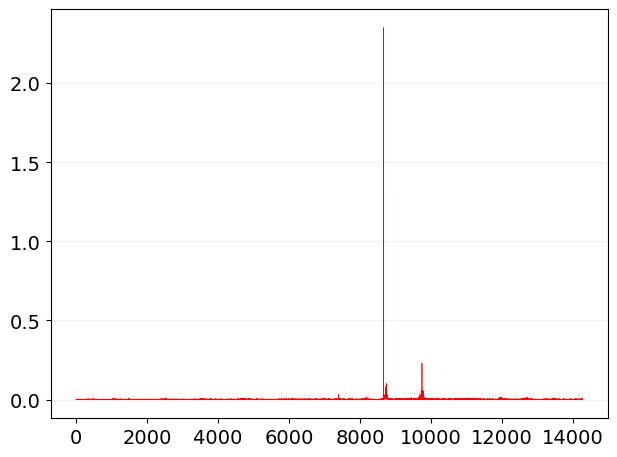

Last RPE between sensors and mocap attitude estimations:
0.005325319888336878
RMSE of RPE between sensors and mocap attitude estimations:
0.020163949242591954


Mean Relative Pose Error of vector g
Mean distance between sensors and mocap vector g estimations:
0.0057696060502503985
STD of distance between sensors and mocap vector g estimations:
0.017120500571498255
Relative Pose Error of vector g


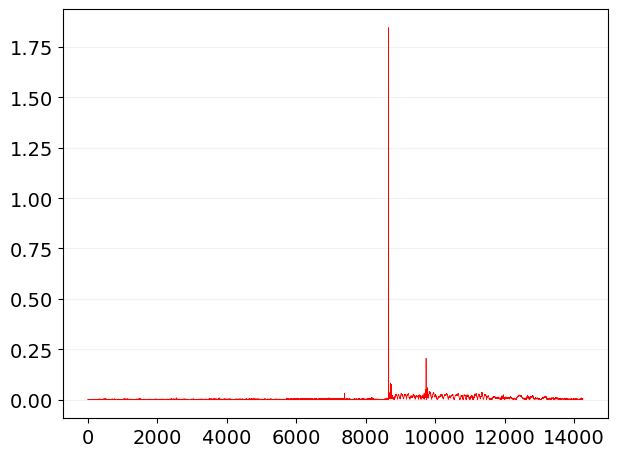

Last RPE between sensors and mocap vector g estimations:
0.0053252896079745956
RMSE of RPE between sensors and mocap vector g estimations:
0.018065971653294384




In [33]:
(errors["madgwick_quat_ape_mean"], errors["madgwick_quat_ape_std"], errors["madgwick_quat_ape_rmse"],
errors["madgwick_quat_ape_g_mean"], errors["madgwick_quat_ape_g_std"], errors["madgwick_quat_ape_g_rmse"],
errors["madgwick_quat_rpe_mean"], errors["madgwick_quat_rpe_std"], errors["madgwick_quat_rpe_rmse"],
errors["madgwick_quat_rpe_g_mean"], errors["madgwick_quat_rpe_g_std"], errors["madgwick_quat_rpe_g_rmse"]) = compare.errors_estimation(madgwick_result.Q, data_mocap_q, source1="sensors")

Mean distance between sensors and mocap RPY attitude estimations:
[0.06871674 0.14684774 1.26419552]
STD of distance between sensors and mocap RPY attitude estimations:
[0.11700723 0.27882995 1.94736534]
Distance between sensors and mocap RPY attitude estimations:


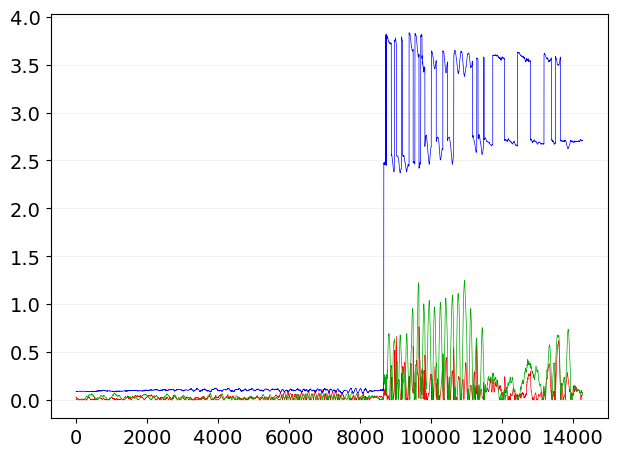

Last distance between sensors and mocap RPY attitude estimations:
[0.07863265 0.05283217 2.70769256]
RMSE of APE between sensors and mocap RPY attitude estimations:
[0.11708854 0.27982594 1.94731601]


Mean distance between sensors and mocap RPY vector g estimations:
[0.0316594  0.02876264 0.00608316]
STD of distance between sensors and mocap RPY vector g estimations:
[0.04594199 0.03957933 0.01144299]
Distance between sensors and mocap RPY vector g estimations:


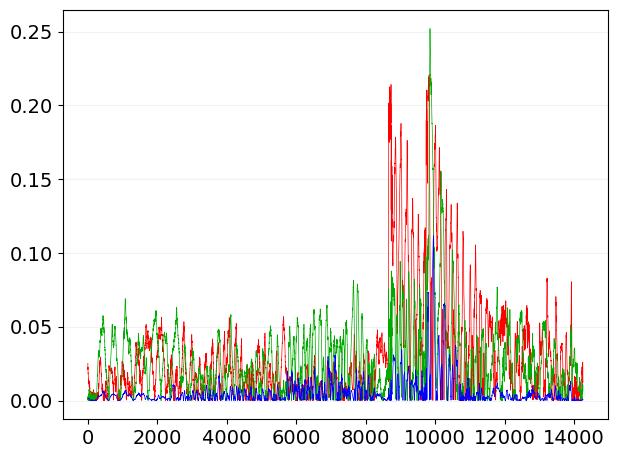

Last distance between sensors and mocap RPY vector g estimations:
[0.01280401 0.01076007 0.00057841]
RMSE of APE between sensors and mocap RPY vector g estimations:
[0.04916001 0.03958845 0.01156495]


Mean Relative Pose Error
Mean distance between sensors and mocap RPY attitude estimations:
[4.60914933 2.03952973 2.10833331]
STD of distance between sensors and mocap RPY attitude estimations:
[74.93127283 18.11782269 21.35908425]
Relative Pose Error RPY


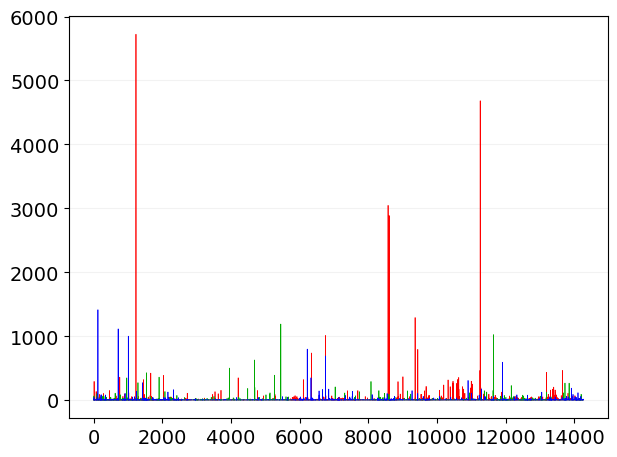

Last RPE between sensors and mocap RPY attitude estimations:
[0. 0. 0.]
RMSE of RPE between sensors and mocap RPY attitude estimations:
[74.92934612 18.12137205 21.37640836]


Mean Relative Pose Error of vector g
Mean distance between sensors and mocap RPY vector g estimations:
[3.16055624 2.44304245 3.11080989]
STD of distance between sensors and mocap RPY vector g estimations:
[52.62297768 26.56520291 59.81629255]
Relative Pose Error RPY of vector g


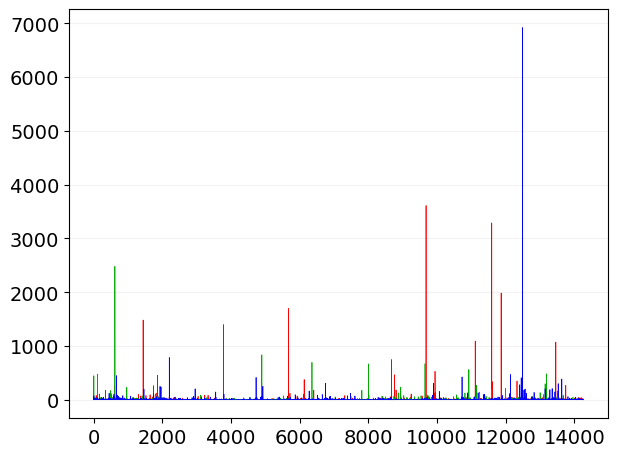

Last RPE between sensors and mocap RPY vector g estimations:
[0. 0. 0.]
RMSE of RPE between sensors and mocap RPY vector g estimations:
[52.64057301 26.58507895 59.81666087]




In [34]:
rpy_sm_aligned = transform.quats_to_rpy(madgwick_result.Q)
rpy_mocap_aligned = transform.quats_to_rpy(data_mocap_q)
(errors["madgwick_rpy_ape_mean"], errors["madgwick_rpy_ape_std"], errors["madgwick_rpy_ape_rmse"],
errors["madgwick_rpy_ape_g_mean"], errors["madgwick_rpy_ape_g_std"], errors["madgwick_rpy_ape_g_rmse"],
errors["madgwick_rpy_rpe_mean"], errors["madgwick_rpy_rpe_std"], errors["madgwick_rpy_rpe_rmse"],
errors["madgwick_rpy_rpe_g_mean"], errors["madgwick_rpy_rpe_g_std"], errors["madgwick_rpy_rpe_g_rmse"]) = compare.errors_estimation_rpy(rpy_sm_aligned, rpy_mocap_aligned, source1="sensors")

# Calculate metrics
We convert the dictionary ```errors``` to the nested dictionary with the purpose of convenient table preparation. Let's use ```collections```. So that we can access metrics in the way: ```dict[filter_name][type: rpy or quat][metric: ape or rpe]```. The final table we prepare using fancy ```prettytable```.

In [126]:
nested_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for composite_key, value in errors.items():
    # Split the key into parts
    parts = composite_key.split('_')
    if len(parts) >= 3:
        model, type_, metric_, metric1 = parts[0], parts[1], parts[2], '_'.join(parts[3:])
        nested_dict[model][type_][metric_][metric1] = value

In [ ]:
from prettytable import PrettyTable

metric = ["ape", "ape_g", "rpe", "rpe_g"]
type = ["rpy", "quat"]
rpy = {0: "roll", 1: "pitch", 2: "yaw"}
quat = {0: "w", 1: "x", 2: "y", 3: "z"}

def make_table(nested_dict, type, metric, idx=None):
    table = PrettyTable()
    dict = {}

    if type == "rpy":
        table.title = f"{type} - {metric} - {rpy[idx]}"
    elif type == "quat":
        table.title = f"{type} - {metric}"

    table.field_names = ["filter", "mean", "std", "rmse", "g_mean", "g_std", "g_rmse"]
    print(nested_dict["iekf"][type])
    for k in nested_dict.keys():
        if idx is not None:
            table.add_row([
                k,
                nested_dict[k][type][metric]["mean"][idx],
                nested_dict[k][type][metric]["std"][idx],
                nested_dict[k][type][metric]["rmse"][idx],
                nested_dict[k][type][metric]["g_mean"][idx],
                nested_dict[k][type][metric]["g_std"][idx],
                nested_dict[k][type][metric]["g_rmse"][idx]
            ])
        else:
            table.add_row([
                k,
                nested_dict[k][type][metric]["mean"],
                nested_dict[k][type][metric]["std"],
                nested_dict[k][type][metric]["rmse"],
                nested_dict[k][type][metric]["g_mean"],
                nested_dict[k][type][metric]["g_std"],
                nested_dict[k][type][metric]["g_rmse"]
            ])
    return table

    

print(make_table(nested_dict, "rpy", "ape", 0))
print(make_table(nested_dict, "rpy", "ape", 1))
print(make_table(nested_dict, "rpy", "ape", 2))

defaultdict(<class 'dict'>, {'ape': {'mean': array([0.10339858, 0.1570343 , 1.54806329]), 'std': array([0.16117913, 0.27350979, 1.99316718]), 'rmse': array([0.16252303, 0.27398309, 2.00132873]), 'g_mean': array([0.01936411, 0.02655647, 0.00508398]), 'g_std': array([0.02686483, 0.03704096, 0.00832233]), 'g_rmse': array([0.02687562, 0.03742038, 0.00836054])}, 'rpe': {'mean': array([3.88497345, 9.67873513, 5.3948822 ]), 'std': array([ 39.4260571 , 155.34921171,  95.88701473]), 'rmse': array([ 39.44033638, 155.37119543,  95.88722176]), 'g_mean': array([5.32262733, 4.15613969, 5.59463321]), 'g_std': array([173.21060723,  70.51200764, 154.38122119]), 'g_rmse': array([173.21038281,  70.53137097, 154.38084428])}})
+------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                rpy - ape - roll                                                        

In [94]:
print(make_table(nested_dict, "rpy", "rpe", 0))
print(make_table(nested_dict, "rpy", "rpe", 1))
print(make_table(nested_dict, "rpy", "rpe", 2))

+----------------------------------------------------------------------------------------------------------------------------------------+
|                                                            rpy - rpe - roll                                                            |
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  filter  |        mean        |        std         |        rmse        |       g_mean       |       g_std        |       g_rmse       |
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   iekf   | 3.8849734454417097 | 39.426057104045675 | 39.44033638429659  | 5.322627329078909  | 173.2106072282153  |  173.210382806182  |
|    pf    | 5.549525722323135  | 143.11971744214225 | 143.13852155375216 | 11.927228952636307 | 183.09569766646246 | 183.10091913345508 |
| madgwick |  4.60914932971

In [124]:
print(make_table(nested_dict, "quat", "ape"))
print(make_table(nested_dict, "quat", "rpe"))

defaultdict(<class 'dict'>, {'ape': {'mean': 1.5293345238123401, 'std': 1.228524116134872, 'rmse': 1.9616395490599305, 'g_mean': 0.037238130718091844, 'g_std': 0.02838768582867939, 'g_rmse': 0.0468239528260713}, 'rpe': {'mean': 0.0026568991364230993, 'std': 0.020657043823287983, 'rmse': 0.020826488860041983, 'g_mean': 0.007964835209119166, 'g_std': 0.02318269539363005, 'g_rmse': 0.024512002446721092}})
+---------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                  quat - ape                                                                 |
+----------+--------------------+--------------------+--------------------+----------------------+----------------------+---------------------+
|  filter  |        mean        |        std         |        rmse        |        g_mean        |        g_std         |        g_rmse       |
+----------+------